# Clasificación de opiniones con NLP (Natural Language Processing)

En este notebook vamos a realizar una práctica de clasificación de opiniones sobre películas (sentiment analisys), siguiendo la [*lesson* 3 del curso de Deep Learning de fastai](https://course.fast.ai/videos/?lesson=3/).

Para ello vamos a emplear un [dataset](http://ai.stanford.edu/~amaas/data/sentiment/) con un total de 100.000 opiniones de la web [IMDb](https://www.imdb.com/) (25.000 positivas, 25.000 negativas y 50.000 no etiquetadas).  Se trata de clasificar las opiniones sobre las películas en positivas y negativas.

Con los siguientes [*magic commands*](https://ipython.readthedocs.io/en/stable/interactive/magics.html/) nos aseguramos de recargar de forma automática cualquier modificación de las librerías o de los gráficos.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Preparamos los datos

Desde *fastai* importamos el módulo *text* para poder trabajar con textos.

In [2]:
from fastai.text import *

Con la función 'untar_data' accedemos, inicialmente, a una muestra del dataset *Large Movie Review Dataset* a través de una URL. En la variable 'path' asignamos la ruta de acceso a dicha muestra.

In [3]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/storage/imdb_sample/texts.csv')]

En la variable 'df' abrimos el archivo 'texts.csv' usando para ello la función 'read_csv' de la librería pandas (pd). Mostramos la cabecera de nuestro *dataframe*.

In [4]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


Como ejemplo, imprimimos en pantalla el texto de la segunda *review* del *dataframe*.

In [5]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

En 'data_lm' creamos el grupo de datos con la función 'TextDataBunch.from_csv'. Le pasamos la ruta ('path') y el nombre del archivo ('texts.csv'). Esta fución hará la conversión de palabras a *tokens* y de ahí a números.

In [6]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

Una vez hecha la conversión, guardamos con 'save()'.

In [7]:
data_lm.save()

Para cargar los datos sin emplear tanto tiempo, podemos utilizar la función 'load_data'.

In [8]:
data = load_data(path)

## "Tokenización"

En primer lugar debemos dividir las frases en "tokens", esto es, en elementos semánticamente indivisibles. También deberemos identificar los elementos de puntuación y limpiar el texto de elementos extraños como por ejemplo código HTML.

Todo esto lo realiza la función 'TextClasDataBunch.from_csv', pasándole la ruta y el nombre del archivo.

In [9]:
data = TextClasDataBunch.from_csv(path, 'texts.csv')

Podemos ver como se ha dividido el texto en *tokens*. También se han añadido algunos *tokens* como 'xxunk' (palabra desconocida) o 'xxmaj' (palabra que empieza en mayúscula).

## Numeralización

Una vez que ya hemos convertido el texto en *tokens*, realizamos la conversión a números. Para ello empleamos la función 'vocab.itos', con la que creamos un diccionario para 'itos' (int to string) almacenar los datos.

Mostramos los 10 primeros.

In [10]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

Mostramos un ejemplo del dataset de entrenamiento.

In [11]:
data.train_ds[0][0]

Text xxbos i 'm fond of this film and it xxunk me that so many " reviewers " rank it below the xxmaj peter xxmaj jackson trilogy . a filmed novel is always interpretive ; in particular an animated film relies on the artist 's vision and should be judged on its own terms . xxmaj speaking as a purist , this is a finer homage to xxmaj tolkien than the updated version . xxmaj while this film has its flaws it stays xxunk to the source , especially so far as the characters are concerned . 
 
  xxmaj in the xxmaj jackson version xxmaj tolkien 's xxmaj frodo is barely recognizable : from the first scenes he is portrayed as a xxunk , constantly xxunk , manipulated by forces around him and never standing on his own two feet ( this is physically and metaphorically true . ) xxmaj you wonder why fate chose this limp xxunk to carry the one ring to the xxmaj xxunk of xxmaj doom . xxmaj jackson xxunk xxunk xxmaj tolkien and robs xxmaj frodo of his finest moment when he allows xxmaj xxunk to rescue him

Mostramos la conversión a números de los 10 primeros *tokens* del ejemplo anterior.

In [12]:
data.train_ds[0][0].data[:10]

array([   2,   19,  166, 4664,   14,   20,   32,   12,   17,    0])

## API de NLP

Con 'TextList.from_csv' creamos una lista que tiene la columna 'text' como item. Con 'split_from_df' dividimos el conjunto de datos en 'train' y 'valid' usando la columna 2, que viene encabezada con 'is_valid'. Con 'label_from_df' asignamos una etiqueta a cada item según lo indicado en la columna 0.

Finalmente, creamos el 'databunch'.

In [15]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

## Creamos el modelo

Para reducir el consumo de memoria, limitamos el lote.

In [5]:
bs = 10

Con 'untar_data', accedemos ahora al dataset completo.

In [17]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/storage/imdb/tmp_lm'),
 PosixPath('/storage/imdb/unsup'),
 PosixPath('/storage/imdb/test'),
 PosixPath('/storage/imdb/README'),
 PosixPath('/storage/imdb/imdb.vocab'),
 PosixPath('/storage/imdb/train'),
 PosixPath('/storage/imdb/tmp_clas')]

In [18]:
(path/'train').ls()

[PosixPath('/storage/imdb/train/neg'),
 PosixPath('/storage/imdb/train/pos'),
 PosixPath('/storage/imdb/train/unsupBow.feat'),
 PosixPath('/storage/imdb/train/labeledBow.feat')]

Para nuestro modelo vamos a crear una lista de texto con 'TextList.from_folder'. Con 'filter_by_folder' filtramos los archivos de texto de los directorios que contengan 'train', 'test' y 'unsup'.
Con 'split_by_rand_pct' dividimos el conjunto de datos con un *validation set* del 10%.
Con 'label_from_lm' etiquetamos los datos, y finalmente, creamos el 'databunch' limitando el *batch size*.

Guardamos esta configuración en 'data_lm.pkl'.

In [ ]:
data_lm = (TextList.from_folder(path)
          .filter_by_folder(include=['train', 'text', 'unsup'])
          .split_by_rand_pct(0.1)
          .label_for_lm()
          .databunch(bs=bs))
data_lm.save('data_lm.pkl')

En la misma variable cargamos de nuevo el *databunch* y el *batch size*.

In [6]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

Mostramos unos ejemplos para ver como han quedado los datos.

In [24]:
data_lm.show_batch()

idx,text
0,"that there 's no real plot -- just a bunch of teens on drugs and their various adventures . xxmaj full of hilarious one liners or lines that make you just howl with laughter . xxmaj incredible set design , lighting and directing ( check out the wallpapers on various characters ' bedrooms ) . xxmaj duval is excellent ( and has plenty of casual nude scenes ) . \n"
1,"laugh tracks often were in the era from which this show evolved -- or if they just had a really easily amused audience . i heard the audience laughing , of all things , at xxmaj dick dancing around in a baggy red sweater while a xxup 3d animated caricature of him xxunk on a monitor screen . xxmaj this mystified me , since the show was created in 2004"
2,"'s . xxmaj the two "" ladies , "" xxmaj mrs. xxmaj robert macphail and xxmaj mrs. xxmaj walter xxmaj davidson , are decked out from their shoes to their hats which were so stylish and sophisticated , and then comes xxmaj sadie . xxmaj she is not a hooker with a heart of gold but more troubled than in need of salvation . xxmaj what i found hard to"
3,"what must the most self - indulgent , esoteric , xxunk one - note joke ever put on art film . xxmaj we have needlessly long- shots , completely disjointed from the movie 's rhyme - scheme , which does nothing but draw attention to the fact that you 're watching a film that desperately craves acknowledgement for its bureaucratic pace and ' artistic ' subtleties . xxmaj but nothing"
4,", it 's not a sickly - sweet boy loves dog movie either , this has got to be one of the most scathing satires ever made . xxmaj the film lumps together elements borrowed from "" xxmaj lassie "" , "" xxmaj rin xxmaj tin xxmaj tin "" , "" xxmaj the littlest xxmaj hobo "" , "" xxmaj skippy the bush kangaroo "" and many more and then"


Creamos el modelo en 'learn'. Le pasamos los datos, le asignamos la arquitectura 'AWD_LSTM' (específica para procesamiento de textos), y configuramos 'drop_mult' en 0.3, lo que escalará el [dropout](https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/) programado por defecto en un 30%.

In [25]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

BUscamos el [*learning rate*](https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/) del modelo.

In [26]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Graficamos el 'lr'. Con 'skip_end' evitamos la parte final de gráfico para poder visualizar mejor la curva del 'lr'.

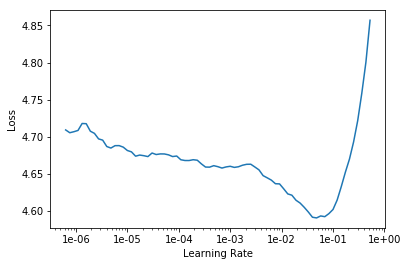

In [27]:
learn.recorder.plot(skip_end=15)

Entrenamos durante una época con un 'lr' de 0.01. Con 'moms' seleccionamos unos *momentums* para variar la velocidad de aprendizaje en finción del *learning rate*. Si el 'lr' es alto el momento será bajo, y si el 'lr' es bajo el momento será alto. 

In [28]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.148712,4.036776,0.294481,1:08:17


Guardamos y cargamos de nuevo.

In [29]:
learn.save('fit_head')

In [30]:
learn.load('fit_head')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (67500 items)
x: LMTextList
xxbos xxmaj dark ( xxmaj james xxmaj duval ) and his friends live in an xxup la with drugs , sex , suicide , murder and such running wild . xxmaj dark just wants to find somebody to love and who loves him back -- male or female . xxmaj oh yeah -- there are aliens wandering around too ( ! ! ! ? ? ? ) xxmaj other than that there 's no real plot -- just a bunch of teens on drugs and their various adventures . xxmaj full of hilarious one liners or lines that make you just howl with laughter . xxmaj incredible set design , lighting and directing ( check out the wallpapers on various characters ' bedrooms ) . xxmaj duval is excellent ( and has plenty of casual nude scenes ) . 
 
  xxmaj always interesting and very well - acted by a xxup very interesting cast . xxmaj not as good as " xxmaj living xxmaj end " or " xxmaj totally xxmaj f**ked xxmaj up " but well worth seeing . xxmaj the sequence that ends the fil

Descongelamos y entrenamos durante 10 épocas y con un 'lr' de 0.001.

In [31]:
learn.unfreeze()

In [32]:
learn.fit_one_cycle(3, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.891366,3.854904,0.314193,1:09:05
1,3.787066,3.772408,0.324604,1:09:13
2,3.684399,3.742306,0.328795,1:09:13


Guardamos el modelo.

In [33]:
learn.save('fine_tuned')

Vamos a hacer una predicción para comprobar como rinde el modelo.

In [ ]:
learn.load('fine_tuned')

In [35]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [36]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75)for _ in range(N_SENTENCES)))

I liked this movie because of the cast , and the acting was very good . Bruce Willis delivers the most of his lines , but he plays a low grade teen who is just as smart as ever . The plot
I liked this movie because it was a very light and entertainment movie . It 's funny , funny , funny , the characters fall in love , the dialogue is funny and the plot is surprisingly well written . i was reminded of


Guardamos también el encoder del modelo (la parte del modelo que actualiza su estado interno).

In [37]:
learn.save_encoder('fine_tuned_enc')

## Creamos el Clasificador.

Creamos un modelo para trabajar con los datos debidamente etiquetados.

Accedemos al dataset.

In [4]:
path = untar_data(URLs.IMDB)

Creamos un nuevo *databunch* donde el *validation set* será el directorio 'test'. Empleamos las etiquetas 'neg' y 'pos'.

In [7]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
            .split_by_folder(valid='test')
            .label_from_folder(classes=['neg', 'pos'])
            .databunch(bs=bs))
data_clas.save('data_clas.pkl')

In [8]:
data_clas = load_data(path, 'data_clas.pkl', bs=10)

Comprobamos que la longitud del vocabulario de 'data_lm' es igual al de 'data_clas'.

In [9]:
len(data_lm.vocab.itos) == len(data_clas.vocab.itos)

True

Mostramos un ejemplo.

In [10]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj what of xxmaj domino did i hate over everything , and i mean everything , else ? xxmaj perhaps it was the overall glorification of being a bounty hunter ; maybe it was the sexism masquerading as an involving and interesting study of a hard bodied female lead character ; maybe it was the mere look of the film with its bizarre yellow glow and distorted blue tints",neg
"xxbos xxmaj the trouble with the book , "" xxmaj memoirs of a xxmaj geisha "" is that it had xxmaj japanese surfaces but underneath the surfaces it was all an xxmaj american man 's way of thinking . xxmaj reading the book is like watching a magnificent ballet with great music , sets , and costumes yet performed by barnyard animals dressed in those xxunk far from xxmaj japanese",neg
"xxbos xxmaj when this film was made , the hippie thing had gone mainstream . xxmaj the ideas of the counter culture was well established , that is why such a big film could be made . xxmaj yet it has something to say , and it is said really beautifully . xxmaj apart from those who 're only waiting for the wanking material , this film is given credit",pos
"xxbos i am not going to lie . xxmaj despite looking interesting , i watched xxmaj the xxmaj notorious xxmaj bettie xxmaj page because i had heard ( and it was fairly obvious just by looking at a synopsis or anything about the film ) , that xxmaj gretchen xxmaj mol got naked in it . i have never been a fan of xxmaj mol , but i can not",pos


Creamos el clasificador y cargamos el encoder. Aquí nos encontramos un problema que no conseguimos solucionar probando diferentes enfoques. Se trata de un problema de tamaño ('torch.Size') entre el nuevo modelo 'learn' y el guardado en 'fine_tuned_enc'. Para no dedicar demasiado tiempo a este notebook y seguir con el curso, vamos a terminar el ejercicio sin cargar el encoder. 

Nuestro modelo no va a rendir como era de esperar.

In [10]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
# learn.load_encoder('fine_tuned_enc')

Determinamos el nuevo 'lr' y lo graficamos.

In [12]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


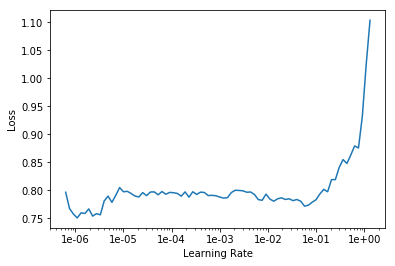

In [13]:
learn.recorder.plot()

Entrenamos durante una época y con un 'lr' de 0.02.

In [14]:
learn.fit_one_cycle(1, 2e-2,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.692702,0.691438,0.552960,34:48


Guardamos y cargamos para volver a entrenar.

In [15]:
learn.save('first')

In [11]:
learn.load('first')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos xxmaj this movie starts out very xxup very slow , but when the action finally gets started , it 's a little had to follow . i could n't understand why some of the events were taking place , and a lot of events happened before they were explained , making them sort of confusing . xxmaj the only thing it really has going for it is the massive amount of blood / gore it has , although most times the special effects are lacking . xxmaj blood looks like red xxmaj kool - xxmaj aid . xxmaj skin tearing sounds like somebody is stepping on a pile of sticks . xxmaj again , the story has a sort of amateur feel to it , like the writer did n't take a long time to perfect it . i feel like it could be a much better movie if the effects were done better and more time was taken on the script . i honestly wish i had n't watched it , not because of the gore , but because i feel that i wasted 90 minutes of my life . xxmaj 

Con la función 'freeze_to(-2), descongelamos todas las capas de la red neuronal excepto la últimas 2.
Entrenamos de nuevo. El 'lr' será ahora un *slice*.

In [12]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-3/(2.6**4), 1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.680239,0.669072,0.606360,34:53


Guradamos estos pesos como 'second' y cargamos.

In [13]:
learn.save('second')

In [14]:
learn.load('second')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos xxmaj this movie starts out very xxup very slow , but when the action finally gets started , it 's a little had to follow . i could n't understand why some of the events were taking place , and a lot of events happened before they were explained , making them sort of confusing . xxmaj the only thing it really has going for it is the massive amount of blood / gore it has , although most times the special effects are lacking . xxmaj blood looks like red xxmaj kool - xxmaj aid . xxmaj skin tearing sounds like somebody is stepping on a pile of sticks . xxmaj again , the story has a sort of amateur feel to it , like the writer did n't take a long time to perfect it . i feel like it could be a much better movie if the effects were done better and more time was taken on the script . i honestly wish i had n't watched it , not because of the gore , but because i feel that i wasted 90 minutes of my life . xxmaj 

Descongelamos todas las capas excepto las 3 útimas, y entrenamos de nuevo. Probamos otro *slice* de 'lr'.

In [15]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-2/(2.6**4), 5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.613208,0.574623,0.712760,35:10


Guardamos y cargamos de nuevo.

In [16]:
learn.save('third')

In [17]:
learn.load('third')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos xxmaj this movie starts out very xxup very slow , but when the action finally gets started , it 's a little had to follow . i could n't understand why some of the events were taking place , and a lot of events happened before they were explained , making them sort of confusing . xxmaj the only thing it really has going for it is the massive amount of blood / gore it has , although most times the special effects are lacking . xxmaj blood looks like red xxmaj kool - xxmaj aid . xxmaj skin tearing sounds like somebody is stepping on a pile of sticks . xxmaj again , the story has a sort of amateur feel to it , like the writer did n't take a long time to perfect it . i feel like it could be a much better movie if the effects were done better and more time was taken on the script . i honestly wish i had n't watched it , not because of the gore , but because i feel that i wasted 90 minutes of my life . xxmaj 

Descongelamos y entrenamos con un nuevo *slice* de 'lr'.

In [18]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(1e-3/(2.6**4), 1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.484783,0.450605,0.813840,36:45


Realizamos un prueba para ver como rinde nuestro modelo.

In [19]:
learn.predict("I really loved that movie, it was awesome!")

(Category neg, tensor(0), tensor([9.9901e-01, 9.9383e-04]))